# Track and summarize experimental data from 20230912

In [1]:
import os
import glob
import numpy as np
import traceback
import dclab
import dctrack

# supress warning from skimage
import warnings
warnings.filterwarnings( 
    "ignore", message="divide by zero encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="invalid value encountered in scalar divide")
warnings.filterwarnings(
    "ignore", message="Polyfit may be poorly conditioned")

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\track.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
project_folder = r"..\..\raw_data\20230914_Felix_HL60_LatB_hyper_channels"
export_folder = r"..\..\tracked_data"

In [3]:
# length of hyperbolic region in um
length_hyper_region = 500
frame_max = None
timeout = None  # 1h 30m

for root, _, _ in os.walk(project_folder):
    if not "tracked_files" in root:
        rtdc_paths = glob.glob(os.path.join(root,"*.rtdc"))
        for file in rtdc_paths:
            print("Analyzing {} \n".format(file))
            # create directory with same structure as Data/RTDC to export data
            file_split = file.split("\\")
            rtdc_idx = file_split.index("RTDC")
            subfolders_export = np.array(file_split)[rtdc_idx+1:-1]
            save_folder = os.path.join(export_folder,"\\".join(subfolders_export))
            if not os.path.isdir(save_folder):
                os.makedirs(save_folder)
            video_folder = os.path.join(save_folder,"Videos")
            if not os.path.isdir(video_folder):
                os.makedirs(video_folder)

            save_path = os.path.join(save_folder, file_split[-1])
            if not os.path.isfile(save_path):
                try:
                    ds = dclab.new_dataset(file)
                    tr_ds = dctrack.track.TrackedDataSet(ds)

                    pix_size = tr_ds.pixel_size
                    tr_ds.tolerance_window = 30

                    tr_ds.channel = True
                    tr_ds.outlet = False
                    if "inlet" in file:
                        tr_ds.inlet = False
                        channel_entry = tr_ds.channel_x_min - 500/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=tr_ds.roi_size_x)
                    else:
                        tr_ds.inlet = True
                        # ROI start 50 um before channel start
                        channel_entry = tr_ds.channel_x_min + 50/pix_size
                        tr_ds.set_channel_values_manual(x_min=0,
                                                        x_max=channel_entry)
                    # start of hyperbolic region in um
                    hyper_start = channel_entry*pix_size + length_hyper_region

                    tr_ds.track(frame_min=0, frame_max=frame_max,
                                timeout=timeout,
                                max_skip_frames=8)
                    tr_ds.time_after_x(hyper_start, return_value=False,
                                       add_to_dataset=True,
                                       variable_name='time_hyper_region')
                    tr_ds.get_ellipse_data(show_progress=False)

                    frame_tracked = tr_ds.dataset['frame'][:][~np.isnan(tr_ds.dataset['object_number'][:])]
                    tr_ds.filter_feature('frame', 0, frame_tracked[-1])

                    export_features = tr_ds.dataset.features_scalar
                    if 'inert_ratio_raw' not in export_features:
                        export_features += ['inert_ratio_raw', 'inert_ratio_cvx']
                    tr_ds.export_tracked_dataset_as_hdf5(path=save_path,
                                                         features=export_features,
                                                         filtered=True,
                                                         override=True,
                                                         compression=None,
                                                         skip_checks=True)

                    video_path = os.path.join(video_folder, os.path.splitext(file_split[-1])[0]+".avi")
                    tr_ds.write_video(save_path=video_path, first_frame=1000, last_frame=3000,
                                      draw_zones=True)
                except:
                    print("An error occured. See below \n")
                    print(traceback.print_exc())

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\0.1nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\100nM_LatB\hyper\M003_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\100nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\10nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\10nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_

Tracking in progress:   0%|          | 0/43752 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/4073 [00:00<?, ?it/s]

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\video.py:118: RuntimeWarning: invalid value encountered in cast
  zone_starts = np.array(dataset['prediction_zone_start']
C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\video.py:120: RuntimeWarning: invalid value encountered in cast
  zone_ends = np.array(dataset['prediction_zone_end']


Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\25nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\50nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\50nM_LatB\hyper\M002_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\50nM_LatB\hyper\M003_data.rtdc 


Tracking in progress:   0%|          | 0/48097 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/2055 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\50nM_LatB\inlet\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\5nM_LatB\hyper\M001_data.rtdc 

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\5nM_LatB\hyper\M002_data.rtdc 


Tracking in progress:   0%|          | 0/43644 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/1754 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\5nM_LatB\hyper\M003_data.rtdc 


Tracking in progress:   0%|          | 0/42179 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/2099 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\5nM_LatB\inlet\M001_data.rtdc 


Tracking in progress:   0%|          | 0/9452 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/444 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\dclab\rtdc_dataset\writer.py:569: RuntimeWarning: All-NaN axis encountered
  val = ufunc(dset)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\dclab\rtdc_dataset\writer.py:579: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(dset)


Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\DMSO\hyper\M002_data.rtdc 


Tracking in progress:   0%|          | 0/24971 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/834 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\DMSO\hyper\M003_data.rtdc 


Tracking in progress:   0%|          | 0/49904 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/1755 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\DMSO\hyper\M004_data.rtdc 


Tracking in progress:   0%|          | 0/49367 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/2033 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

Analyzing Y:\Data\RTDC\20230914_Felix_HL60_LatB_hyper_channels\DMSO\inlet\M001_data.rtdc 


Tracking in progress:   0%|          | 0/9879 [00:00<?, ?it/s]

Computing velocities:   0%|          | 0/312 [00:00<?, ?it/s]

Writing video:   0%|          | 0/2000 [00:00<?, ?it/s]

## Summarize results

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')
from tqdm.notebook import tqdm
from scripts.stress_hyper import (shear_stress_hyper_wc60_lc500_ell_20230816,
                                  normal_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_ell_20230817,
                                  total_stress_hyper_wc60_lc500_20230801,
                                  shear_stress_hyper_wc60_lc500_20230801,
                                  normal_stress_hyper_wc60_lc500_20230621)
from scripts.extensional_paras import (fit_velocity,
                                       extension_rate_from_velocity_poly,
                                       recalculate_time)

In [5]:
# for some reason need to re-register the ellipse features
ell_features = ['ell_cx', 'ell_cy', 'ell_major', 'ell_minor', 'ell_angle']
for ell_feat in ell_features:
    if not dclab.definitions.feature_exists(ell_feat):
        dclab.register_temporary_feature(feature=ell_feat)

In [6]:
def compute_extensional_paras(tr_ds,
                              hyper_start=None, hyper_end=None,
                              stable_region_start=None,
                              filter=False, **filter_kws):
    """
    :param tr_ds: tracked_dataset instance of dctrack
    :return: df: dataframe with additional analysis parameters
    """
    if filter:
        tr_ds.filter_obj_distance = True
        tr_ds.filter_obj_n_events = True
        tr_ds.filter_backward_movement = True
        tr_ds.filter(inplace=True, return_filtered_ds=False, **filter_kws)

    df = tr_ds.get_extensional_paras_dataframe(hyper_start=hyper_start,
                                               hyper_end=hyper_end,
                                               stable_extension_start=stable_region_start
                                               )
    return df

def get_folder_data(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 2)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_max * tr_ds.pixel_size + 500
        # stable region 100 µm in the hyperbola
        # (flow right to left -> negative sign)
        stable_region_start = hyper_start - 150

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       stable_region_start=stable_region_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)

        # only use data in linear regime for fitting
        df_filtered = df[(150 < df['x_hyper']) & (df['x_hyper'] < 450)]
        x_fit = np.array(df_filtered['x_hyper']) *1e-6 #  in m
        y_fit = np.array(df_filtered['velocity'])
        idx = np.isfinite(x_fit) & np.isfinite(y_fit)
        p, cov = np.polyfit(x_fit[idx], y_fit[idx], 1, cov=True)
        fit_errs = np.sqrt(np.diag(cov))

        df['extension_rate_sample'] = abs(p[0])
        df['extension_rate_sample_err'] = fit_errs[0]
        df['flow_rate'] = flow_rate

        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

def df_fit_values(df_in, x_feature='x_shift', time_label='time_shift', poly_degree=7, x_0=-60,
                  pixel_size=0.68):
    df_temp = df_in.copy()
    df_out = pd.DataFrame()
    flow_rates = df_temp['flow_rate'].unique()
    pbar = tqdm(flow_rates, desc="Iterating over flow_rates")
    for fr in pbar:
        df = df_temp[df_temp['flow_rate'] == fr].copy()
        df['x_shift'] = df['x_hyper'] - x_0
        x = df[x_feature]
        velocity_poly = fit_velocity(df, x_feature=x_feature, degree=poly_degree)
        df['velocity_fit'] = velocity_poly(x)
        er = extension_rate_from_velocity_poly(x, velocity_poly)
        df['extension_rate_fit'] = er
        df = recalculate_time(df, velocity_poly,
                              x_feature=x_feature,
                              time_label=time_label)
        # repeat time calculation for x_hyper -> time_hyper
        velocity_poly = fit_velocity(df, x_feature='x_hyper', degree=poly_degree)
        df = recalculate_time(df, velocity_poly,
                              x_feature='x_hyper',
                              time_label='time_hyper')
        df_out = pd.concat([df_out, df])

    extension_rate = df_out['extension_rate_fit']
    pos_x = df_out['x_hyper']
    # calculate diameter from ellipse fit
    # ellipse features calculated in pixels
    diameter = 2 * np.sqrt(pixel_size**2 * df_out['ell_major'] * df_out['ell_minor'])
    flow_rate = df_out['flow_rate']

    df_out['stress_ir'] = total_stress_hyper_wc60_lc500_20230801(extension_rate,
                                                                 pos_x,
                                                                 diameter,
                                                                 flow_rate)
    df_out['shear_stress_ir'] = shear_stress_hyper_wc60_lc500_20230801(pos_x,
                                                                       diameter,
                                                                       flow_rate)
    df_out['normal_stress_ir'] = normal_stress_hyper_wc60_lc500_20230621(extension_rate)
    df_out['stress_ell'] = total_stress_hyper_wc60_lc500_ell_20230817(
        extension_rate, pos_x, diameter, flow_rate)
    df_out['shear_stress_ell'] = shear_stress_hyper_wc60_lc500_ell_20230816(
        pos_x, diameter, flow_rate)
    df_out['normal_stress_ell'] \
        = normal_stress_hyper_wc60_lc500_ell_20230817(extension_rate)

    return df_out

In [7]:
project_folder = r"T:\Members\Felix\analysis_data\RTDC\20230914_Felix_HL60_LatB_hyper_channels"
folder_names = ["DMSO",
                "0.1nM_LatB",
                "1nM_LatB",
                "5nM_LatB",
                "10nM_LatB",
                "25nM_LatB",
                "50nM_LatB",
                "100nM_LatB",
                "250nM_LatB",
                ]

In [11]:
data_exports = r"..\data_exports"

In [12]:
# data_folder = r"T:\Members\Felix\analysis_data\analysis_hyperbolic_channels\data_exports\20230323_HL60_LatB\exports_20230821"
data_folder = os.path.join(data_exports, "20230914_HL60_LatB", "exports_20230915")
if not os.path.isdir(data_folder):
    os.makedirs(data_folder)

##### Create and save one dataframe for all hyper data from 20230912
Need to create individual files for each sample because loop breaks often.

In [13]:
x0 = -50
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_hyper.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "hyper")
        if folder == "DMSO":
            concentration = 0
        else:
            concentration = float(folder.split("_")[0][:-2])
        df_cc = get_folder_data(data_dir)

        df_cc = df_fit_values(df_cc[df_cc['x_hyper'] < 520].copy(), x_0=x0)
        df_cc['LatB concentration'] = concentration

        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/9 [00:00<?, ?it/s]

Analyzing:  DMSO


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  0.1nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  1nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  5nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  10nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  25nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  50nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  100nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Analyzing:  250nM_LatB


  0%|          | 0/3 [00:00<?, ?it/s]

Iterating over flow_rates:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [14]:
df_20230914 = pd.DataFrame()
files_20230914 = glob.glob(os.path.join(data_folder, "*hyper.tsv"))
for file in tqdm(files_20230914):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20230914 = pd.concat([df_20230914, df_cc], ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# df_20230914.drop(columns=['Unnamed: 0'], inplace=True)
df_20230914['date'] = '20230914'
df_20230914['wc'] = 60
df_20230914['strain_inert'] = df_20230914['inert_ratio_raw'] - 1
# ellipse features
df_20230914['net_strain_ell'] = (df_20230914['ell_major'] - df_20230914['ell_minor']) \
                                / np.sqrt(df_20230914['ell_major'] * df_20230914['ell_minor'])
df_20230914['taylor_strain_ell'] = (df_20230914['ell_major'] - df_20230914['ell_minor']) \
                                   / (df_20230914['ell_major'] + df_20230914['ell_minor'])

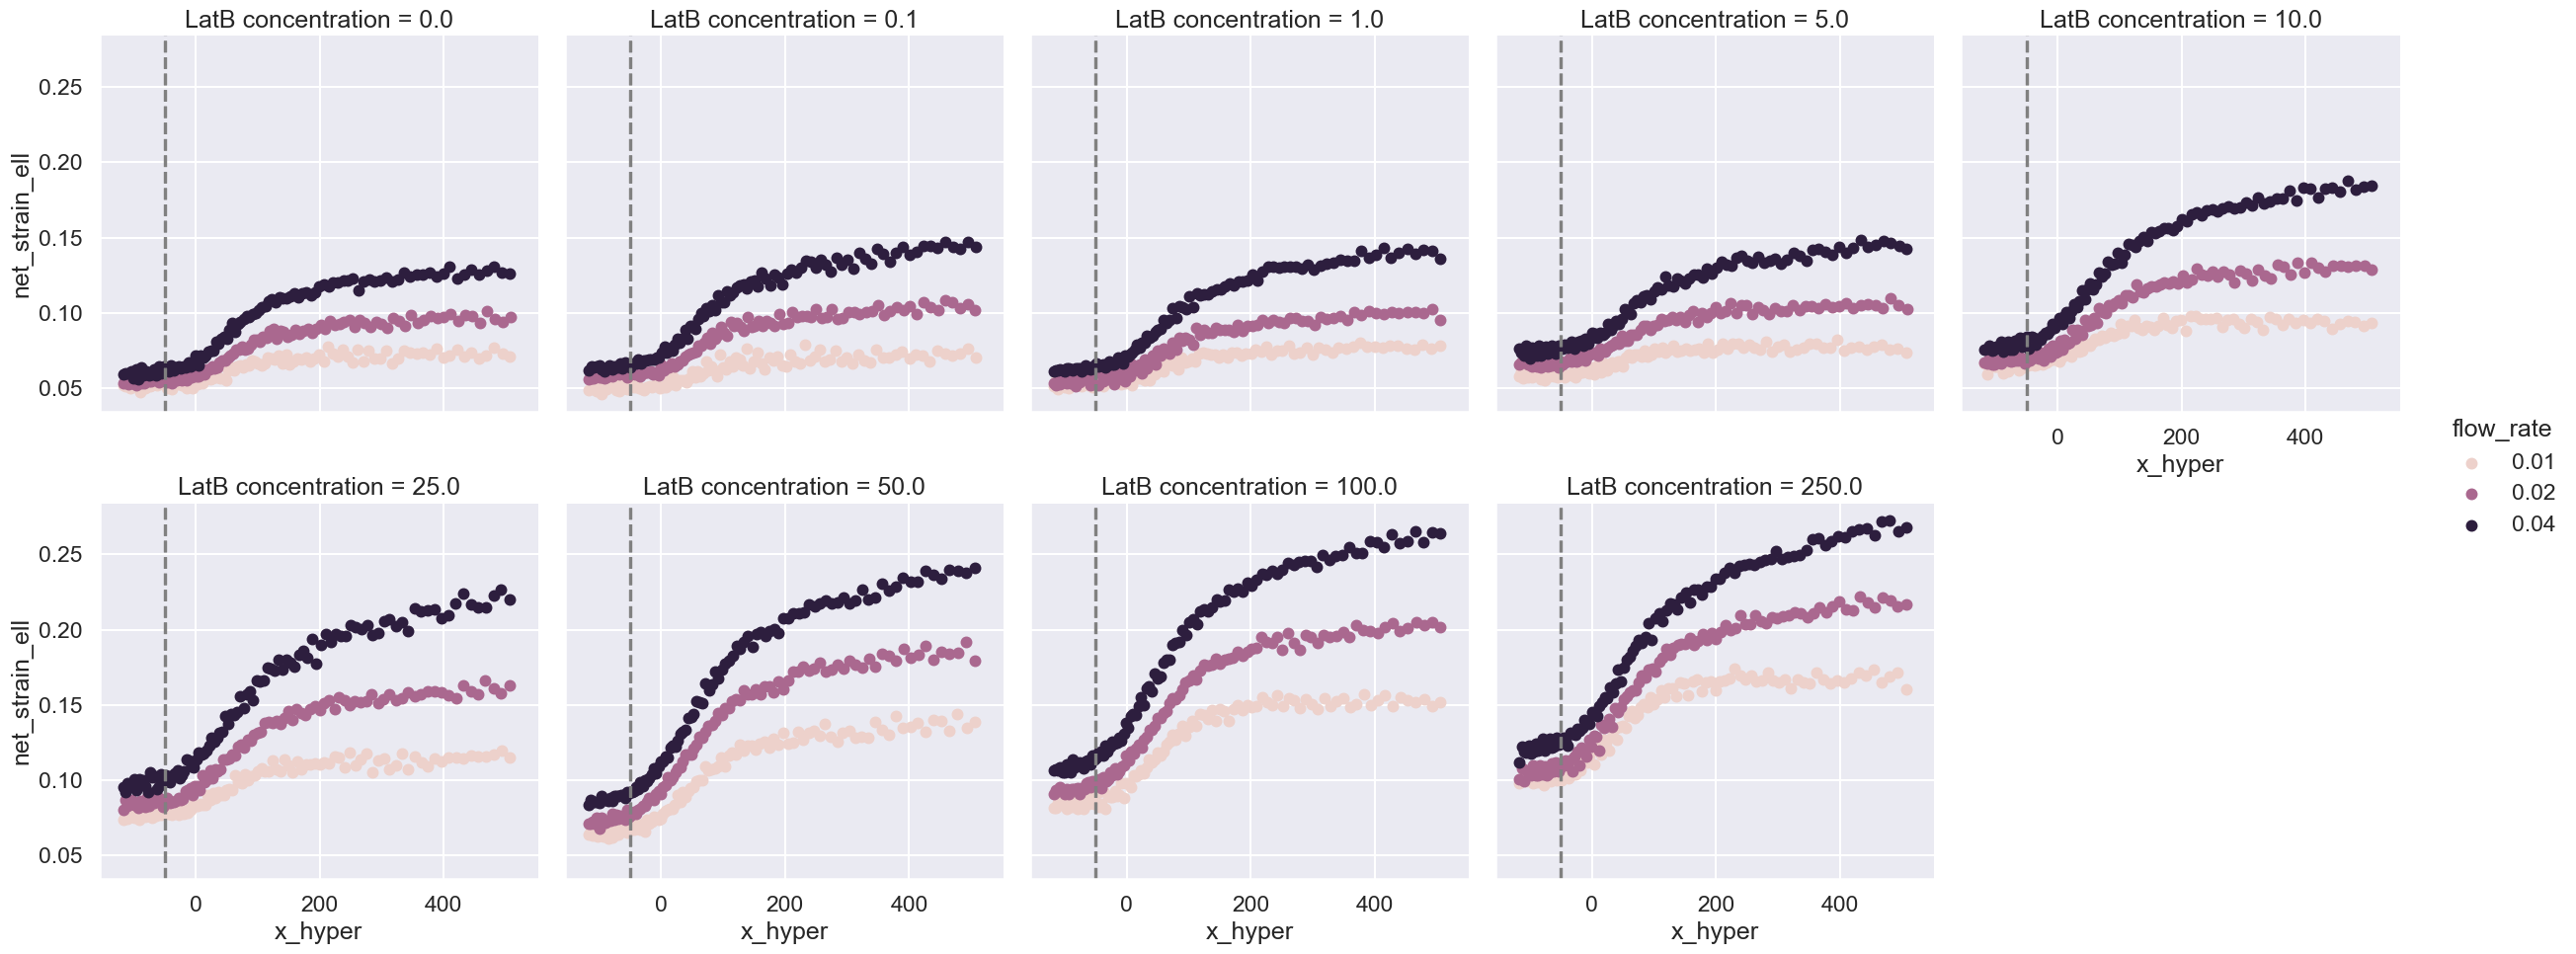

In [16]:
g = sns.lmplot(data=df_20230914,
               x='x_hyper', y='net_strain_ell', hue='flow_rate', palette='ch:',
               col='LatB concentration', col_wrap=5,
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
g.refline(x=x0, markersize=0)
plt.show()

In [17]:
df_20230914

area_msd  area_ratio     area_um    aspect  bright_avg  bright_sd  \
0           265.0    1.033962  126.697610  1.166667  125.542660  24.832869   
1           264.5    1.032136  126.235210  1.166667  123.811646  24.662700   
2           263.0    1.026616  124.848010  1.166667  124.165520  25.166758   
3           264.5    1.028355  125.772804  1.052632  124.359590  25.690815   
4           264.0    1.041667  127.160000  1.052632  124.051370  25.523440   
...           ...         ...         ...       ...         ...        ...   
1350441     345.5    1.033285  165.076810  1.095238  117.286470  23.273890   
1350442     344.0    1.033430  164.383210  1.095238  118.277336  23.993841   
1350443     347.5    1.028777  165.308010  1.095238  117.364110  24.221262   
1350444     344.5    1.036284  165.076810  1.142857  117.722664  24.748718   
1350445     341.5    1.026354  162.071210  1.095238  116.803764  24.839304   

             circ    deform  ell_angle      ell_cx  ...  normal_stress_ir  \
0        0.983959  0.016041   2.990776  978.263305  ...          0.365999   
1        0.983884  0.016116   2.968355  967.391275  ...          0.209324   
2        0.982816  0.017184   2.993503  956.562138  ...          0.118519   
3        0.983040  0.016960   2.971081  945.670245  ...          0.071015   
4        0.986434  0.013566   2.967257  934.704727  ...          0.051103   
...           ...       ...        ...         ...  ...               ...   
1350441  0.987328  0.012672   3.080277  300.089519  ...         20.503012   
1350442  0.984629  0.015371   3.000829  250.428404  ...         19.645351   
1350443  0.988089  0.011911   3.086329  197.960940  ...         18.371560   
1350444  0.985043  0.014958   3.019117  142.621106  ...         16.533833   
1350445  0.987496  0.012504   3.063108   84.467323  ...         14.715223   

         stress_ell  shear_stress_ell  normal_stress_ell  LatB concentration  \
0          0.969621          0.183592           0.786029                 0.1   
1          0.678340          0.183139           0.495201                 0.1   
2          0.491287          0.181894           0.309393                 0.1   
3          0.385820          0.183248           0.202571                 0.1   
4          0.337164          0.182848           0.154316                 0.1   
...             ...               ...                ...                 ...   
1350441   34.048819         12.113493          21.935326                 0.0   
1350442   34.342840         13.169054          21.173786                 0.0   
1350443   34.454799         14.422803          20.031996                 0.0   
1350444   33.869199         15.509107          18.360092                 0.0   
1350445   33.306846         16.633296          16.673550                 0.0   

             date  wc  strain_inert  net_strain_ell  taylor_strain_ell  
0        20230914  60      0.159567        0.157785           0.078648  
1        20230914  60      0.151476        0.151079           0.075325  
2        20230914  60      0.129718        0.128950           0.064341  
3        20230914  60      0.107628        0.105101           0.052478  
4        20230914  60      0.103728        0.102595           0.051230  
...           ...  ..           ...             ...                ...  
1350441  20230914  60      0.115225        0.107193           0.053519  
1350442  20230914  60      0.090016        0.086063           0.042992  
1350443  20230914  60      0.109806        0.101894           0.050881  
1350444  20230914  60      0.095714        0.093229           0.046564  
1350445  20230914  60      0.102441        0.098274           0.049078  

[1350446 rows x 66 columns]

In [18]:
filename = "20230915_hl60_latb_hyper.tsv"
df_20230914.to_csv(os.path.join(data_folder, filename), sep='\t')
print("Done")

Done


### Summarize inlet data

In [19]:
def get_folder_data_inlet(folder):
    # print("Analyzing ", folder)
    files = glob.glob(os.path.join(folder, "*.rtdc"))

    df_folder = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)
        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 3)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_min * tr_ds.pixel_size - 500

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)
        df['flow_rate'] = flow_rate
        roi_size_x = tr_ds.dataset.config['imaging']['roi size x']
        pix_size = tr_ds.dataset.config['imaging']['pixel size']
        df['pos_x_center'] = df['pos_x'] - roi_size_x * pix_size / 2

        df_folder = pd.concat([df_folder, df])

    return df_folder

In [20]:
for folder in tqdm(folder_names):
    print("Analyzing: ", folder)
    save_path = os.path.join(data_folder, folder + "_inlet.tsv")

    if not os.path.isfile(save_path):
        data_dir = os.path.join(project_folder, folder, "inlet")
        if folder == "DMSO":
            concentration = 0
        else:
            concentration = float(folder.split("_")[0][:-2])
        df_cc = get_folder_data_inlet(data_dir)
        df_cc['LatB concentration'] = concentration

        df_cc.to_csv(save_path, sep='\t')

  0%|          | 0/9 [00:00<?, ?it/s]

Analyzing:  DMSO


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  0.1nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  1nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  5nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  10nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  25nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  50nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  100nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

Analyzing:  250nM_LatB


  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
df_20230914_inlet = pd.DataFrame()
files_20230914_inlet = glob.glob(os.path.join(data_folder, "*inlet.tsv"))
for file in tqdm(files_20230914_inlet):
    df_cc = pd.read_csv(os.path.join(data_folder, file), sep='\t', index_col=0)
    df_20230914_inlet = pd.concat([df_20230914_inlet, df_cc], ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [22]:
# df_20230914_inlet.drop(columns=['Unnamed: 0'], inplace=True)
df_20230914_inlet['date'] = '20230914'
df_20230914_inlet['wc'] = 60
df_20230914_inlet['strain_inert'] = df_20230914_inlet['inert_ratio_raw'] - 1
# ellipse features
df_20230914_inlet['net_strain_ell'] \
    = (df_20230914_inlet['ell_major'] - df_20230914_inlet['ell_minor']) \
      / np.sqrt(df_20230914_inlet['ell_major'] * df_20230914_inlet['ell_minor'])
df_20230914_inlet['taylor_strain_ell'] \
    = (df_20230914_inlet['ell_major'] - df_20230914_inlet['ell_minor']) \
      / (df_20230914_inlet['ell_major'] * df_20230914_inlet['ell_minor'])

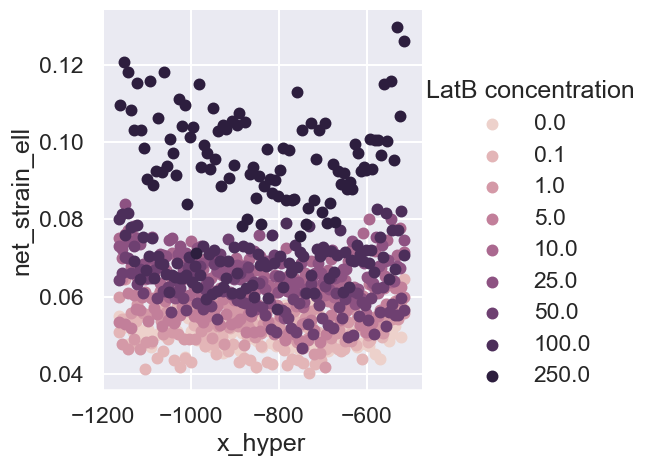

In [23]:
g = sns.lmplot(data=df_20230914_inlet,
               x='x_hyper', y='net_strain_ell', 
               hue='LatB concentration', palette='ch:',
               x_bins=100, x_estimator=np.median, fit_reg=False, ci=None,
               facet_kws={'sharey': True})
# g.refline(x=x0, markersize=0)
plt.show()

In [24]:
filename = "20230915_hl60_latb_inlet.tsv"
df_20230914_inlet.to_csv(os.path.join(data_folder, filename), sep='\t')
print("Done")

Done
